---
CSC 268 Lab 3: Interpolation
---

This lab will begin to investigate interpolation for image resampling.  It includes a mix of calculations (you can write your answers right in the lab) and computations.

### Linear Interpolation

Let's begin with a linear interpolation in one dimension, done by hand.  Suppose that you have three successive pixel values:  2, 11, 8.  You want to resample these with two new points between each of the existing ones.  If we assume (arbitrarily) that the original points are at `x` coordinates 0, 1, and 2, then the new points will be sampled at 0, 1/3, 2/3, 1, 4/3, 5/3, 2.

__Questions__:  
1. What is the value of `y_0` for each point?  (This is the known point to the left.)
2. What is the value of `y_1` for each point?  (This is the known point to the right.)
3. What is the value of `f` for each point?  (This is the fractional distance between `x_0` and `x_1`.)
4. What would the interpolated value be at each point?  Recall the formula `y = (1-f)*y_0 + f*y_1`

1. 0, 0, 0, 1, 1, 1, 2 
2. 1, 1, 1, 2, 2, 2, 3
3. 0, 1/3, 2/3, 0, 1/3, 2/3, 0
4. 2, 5, 8, 11, 10, 9, 8

Now let's try that in code in two dimensions.  We'll take an existing low-res image and triple the number of points.  To avoid edge effects, we'll add extra pixels all around the outside of the image.

(1328, 973, 3)


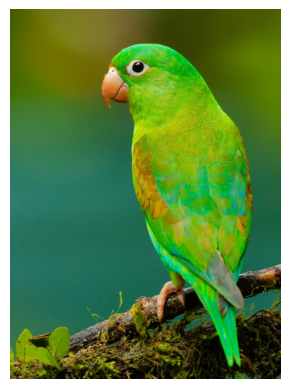

(1330, 975, 3)


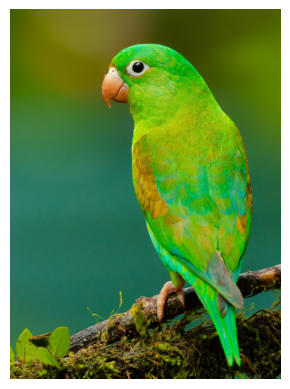

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')

def imshow(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
para = cv.imread('parakeet_low.jpg',cv.IMREAD_COLOR)[:,:,[2,1,0]]/255.0
orig_size = para.shape
print(orig_size)
imshow(para)
para = cv.copyMakeBorder(para,1,1,1,1,cv.BORDER_REFLECT)
print(para.shape)
imshow(para)

Next we will create grids of the x and y coordinates for our newly sampled points.  We'll add points on either side of our original points, so our first coordinates will begin at 2/3.

(2919,)
0.6666666666666666 973.3333333333334
(3984, 2919)


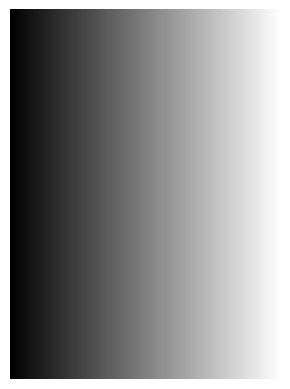

(3984,)
0.6666666666666666 1328.3333333333333
(3984, 2919)


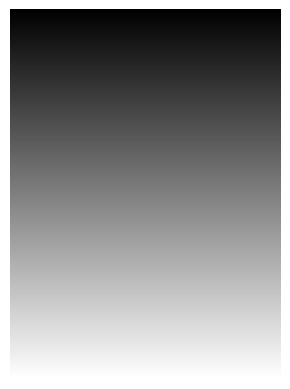

In [18]:
# create the grid of x coordinates
px = np.array(range(2,3*973+2))/3.0
print(px.shape)
print(px[0],px[-1])
px = np.tile(px.reshape(1,-1),(1328*3,1))
print(px.shape)
imshow(px/px.max())

# create the grid of y coordinates
py = np.array(range(2,3*1328+2))/3.0
print(py.shape)
print(py[0],py[-1])
py = np.tile(py.reshape(-1,1),(1,973*3))
print(py.shape)
imshow(py/py.max())

Now we can figure out `x0`, `y0`, `x1`, and `y1` for each point, as well as the fractional values in each direction `fx` and `fy`.

In [27]:
x0 = np.floor(px).astype(np.int32)
x1 = np.ceil(px).astype(np.int32)
fx = px-x0
# add code to compute the corresponding y values...
y0 = np.floor(py).astype(np.int32)
y1 = np.ceil(py).astype(np.int32)
fy = py-y0

Finally we put it all together, applying the formula for bilinear interpolation.  And voila!  We get... the same image.  Only it has 9 times as many pixels as before!

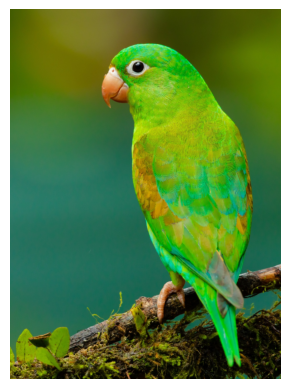

(3984, 2919, 3)


In [28]:
para3 = np.zeros((1328*3,973*3,3),np.float32)
for c in range(3):
    para3[:,:,c] = (1-fx)*(1-fy)*para[y0,x0,c]+fx*(1-fy)*para[y1,x0,c]+(1-fx)*fy*para[y0,x1,c]+fx*fy*para[y1,x1,c]
imshow(para3)
print(para3.shape)

### Cubic Interpolation

Because bicubic interpolation is more complicated, we'll just do a single 1D computation by hand.  Remember that the bicubic interpolation simply involves four 1D interpolations along one axis, and a final 1d interpolation along the other axis.  Code to make this computation is longer than the bilinear case but still just a matter of working out the results.

Suppose that we have the four data points 11, 5, 23, and 113.  We can fit a cubic polynomial to estimate values between the middle two points.

__Questions__:  
1. What are the values of `a`, `b`, `c`, and `d` (the coefficients of the polynomial)?
2. What is the interpolated value halfway between the two middle points?

1. a = -11/2+3*5/2-3*23/2+113/2 = 24;  b = 11-5*5/2+2*23-113/2 = -12;  c = -11/2+23/2 = 6, d = 5
2. f(1/2) = 24*(1/2)^3 - 12*(1/2)^2 + 6*(1/2) + 5 = 8